In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
import json

with open('data/label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    print(mapping)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [3]:
df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [5]:
def visualize(img_list):
    rows = 3
    cols = 3

    plt.figure(figsize=(18, 10))

    for i in range(rows*cols):
        plt.subplot(10/cols+1, cols, i+1)
        r = np.random.randint(len(img_list))
        img_path = "data/train_images/" + str(img_list[r])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(img_list[r]))
        plt.imshow(img)
       

    plt.tight_layout()
    plt.show()

## Class 0 : Cassava Bacterial Blight (CBB)¶

<ipython-input-5-156cfda34898>:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(10/cols+1, cols, i+1)


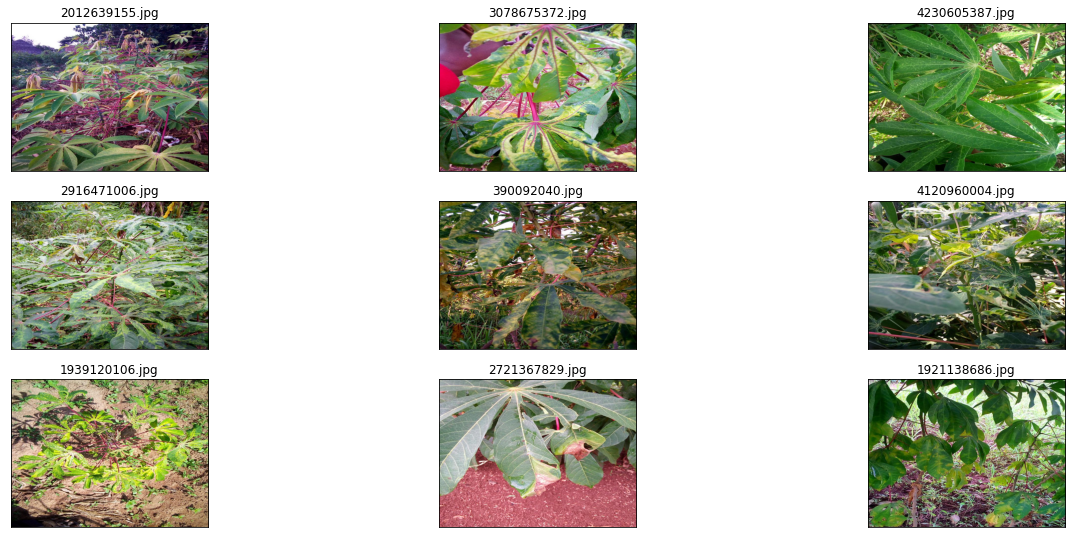

In [6]:
cbb_df = df[df['label'].isin([0])]
cbb_img_list = list(df['image_id'])

visualize(cbb_img_list)

## Class 1 : Cassava Brown Streak Disease (CBSD)¶

In [ ]:
cbb_df = df[df['label'].isin([0])]
cbb_img_list = list(df['image_id'])

visualize(cbb_img_list)

In [7]:
from os import listdir
from os.path import isfile, join

mypath = "data/train_tfrecords"
filenames = [f for f in listdir(mypath) if isfile(join(mypath, f))]
filenames

['ld_train00-1338.tfrec',
 'ld_train01-1338.tfrec',
 'ld_train02-1338.tfrec',
 'ld_train03-1338.tfrec',
 'ld_train04-1338.tfrec',
 'ld_train05-1338.tfrec',
 'ld_train06-1338.tfrec',
 'ld_train07-1338.tfrec',
 'ld_train08-1338.tfrec',
 'ld_train09-1338.tfrec',
 'ld_train10-1338.tfrec',
 'ld_train11-1338.tfrec',
 'ld_train12-1338.tfrec',
 'ld_train13-1338.tfrec',
 'ld_train14-1338.tfrec',
 'ld_train15-1327.tfrec']

## Data transformation with tf.data

In [4]:
BATCH_SIZE = 16
TARGET_SIZE = 224
BASE_DIR = "data/"
EPOCHS = 10

In [5]:
def preprocess(image):
    #Converting to numpy array from numpy tensor with rank 3
    image = np.array(image, dtype=np.uint8)
    #Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(image,(5,5),0)
    img = np.asarray(gaussian_blur, dtype=np.float64)
    return img

In [10]:
#Converting labels to string to use sparse class mode
df.label = df.label.astype('str')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Training  Augumentation
datagen = ImageDataGenerator(rescale=1.0/255,
                             featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=30,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             shear_range=15.0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             brightness_range=[0.2, 0.8],
                             validation_split=0.2,
                             fill_mode='nearest',
                             preprocessing_function=preprocess)


train_datagen = datagen.flow_from_dataframe(df,
                                            directory = os.path.join(BASE_DIR, "train_images"),
                                            subset = "training",
                                            x_col = "image_id",
                                            y_col = "label",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

#Validation
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split=0.2,
                                       preprocessing_function=preprocess)


valid_datagen = validation_datagen.flow_from_dataframe(df,
                                            directory = os.path.join(BASE_DIR, "train_images"),
                                            subset = "validation",
                                            x_col = "image_id",
                                            y_col = "label",
                                            target_size = (TARGET_SIZE, TARGET_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
# train_dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=2)
# train_dataset 

## Modeling

In [20]:
#He Uniform Initializer for Dense Layer

# import tensorflow as tf
def my_init(shape, dtype=None):
    initializer = tf.keras.initializers.he_uniform(seed = 1)
    return initializer(shape, dtype=dtype)

In [ ]:
!pip install -U efficientnet

In [32]:
from efficientnet.tfkeras import EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold

base_model = EfficientNetB3(weights = 'imagenet', include_top=False, input_shape = (TARGET_SIZE, TARGET_SIZE, 3), pooling=None)

base_output = base_model.output
pooling_layer = layers.GlobalAveragePooling2D()(base_output)
Dense1 = layers.Dense(256, activation = "relu", kernel_initializer=my_init)(pooling_layer)
BN1 = layers.BatchNormalization()(Dense1)
dropout = layers.Dropout(0.2)(BN1)
model = layers.Dense(5, activation="softmax")(dropout)

model = models.Model(base_model.input, model)

model.compile(optimizer = 'adam', 
              loss = "sparse_categorical_crossentropy", 
              metrics=["acc"])
model.summary()


Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 40) 1080        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 40) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import datetime


filepath = "cassava.h5"

log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1),
             EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True),
             TensorBoard(log_dir=log_dir, histogram_freq=1)]

In [17]:
history = model.fit(train_datagen, epochs = EPOCHS,verbose=0, validation_data = valid_datagen, callbacks=callbacks)


Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


## INFERENCE PIPELINE

In [37]:

from PIL import Image
import cv2

# Load model weights
model.load_weights("cassava.h5")

im = []

test_image = "data/test_images/2216849948.jpg"

#Read image
image = cv2.imread(test_image)

image_from_array = Image.fromarray(image, 'RGB')
size_image = image_from_array.resize((224, 224))
im.append(np.array(size_image))
fv=np.array(im)
fv = fv.astype('float32')/255
prediction = model.predict(fv)


In [38]:
prediction

array([[0.02937136, 0.02701602, 0.17024222, 0.16380645, 0.6095639 ]],
      dtype=float32)